In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import random
import logging
logging.basicConfig(level=logging.INFO, filename='demo.log', format='%(asctime)s   %(levelname)s   %(message)s')
%matplotlib notebook

In [2]:
class WBChess:
    def __init__(self):
        self.init_mat()
        self.x_max = self.mat.shape[0]
        self.y_max = self.mat.shape[1]
        self.player = 1
        self.plot_circle_chess = []
        
        fig, ax = plt.subplots()
        fig.set_size_inches(5.6, 5.8)
        ax.set_xlim([0,8])
        ax.set_ylim([0,8])
        for i in range(1,8):
            plt.axvline(i, c='black', lw=1)
            plt.axhline(i, c='black', lw=1)
        self.fig = fig
        self.ax = ax
        self.init_board()
        self._status = 1 # 1: 正常比赛, 2: 无可放棋子->对方走, 3: 无棋子->输了, 4: 棋盘放满->结束,
        self._white = 2
        self._black = 2
    
    def init_mat(self):
        self.mat = np.zeros((8,8))
        self.mat[3][3] = 1
        self.mat[3][4] = -1
        self.mat[4][3] = -1
        self.mat[4][4] = 1
        self._status = 1 # 1: 正常比赛, 2: 无可放棋子->对方走, 3: 无棋子->输了, 4: 棋盘放满->结束,
        self._white = 2
        self._black = 2
        
    def init_board(self):
        circles = []
        
        def draw_black_chess(i, j, r=0.4):
            return plt.Circle((i+0.5, j+0.5), r, color='black')

        def draw_white_chess(i, j, r=0.4):
            return plt.Circle((i+0.5, j+0.5), r, edgecolor='black', facecolor='white')

        def draw_available_chess(i, j, r=0.4, alpha=0.9):
            return plt.Circle((i+0.5, j+0.5), r, edgecolor='green', facecolor='lightgrey', alpha=alpha, ls='--')
        
        for i in range(self.x_max):
            circles.append([])
            for j in range(self.y_max):
                circles[i].append([])
                circles[i][j].append(draw_white_chess(i, j))
                circles[i][j].append(draw_black_chess(i, j))
                circles[i][j].append(draw_available_chess(i, j))
                for k in range(3):
                    circles[i][j][k].set_visible(False)
                    self.ax.add_patch(circles[i][j][k])
        self.board = circles
    
    def change_player(self):
        self.player *= -1
    
    def get_plyer_name(self):
        return "黑棋" if self.player == 1 else "白棋"
        
    def gather_statics(self):
        w, b = 0, 0
        for i in range(self.x_max):
            for j in range(self.y_max):
                if self.mat[i][j] == 1:
                    b += 1
                if self.mat[i][j] == -1:
                    w += 1
        self._white = w
        self._black = b
        
    def clear_cell(self, x, y):
        for k in range(3):
            self.board[x][y][k].set_visible(False)

    def set_cell(self, x, y, idx):
        self.clear_cell(x, y)
        self.board[x][y][idx].set_visible(True)
            
    def pos_in_boundary(self, x, y):
        return 0 <= x and x < self.x_max and 0 <= y  and y < self.y_max
    
    def enemy_in_neighbor(self, x, y, enemy):
        mat = self.mat
        return self.pos_in_boundary(x, y) and mat[x][y] == enemy

    def ally_in_remote(self, x, y, dx, dy, player):
        enemy = player * -1
        mat = self.mat
        while True:
            x += dx
            y += dy
            if not self.pos_in_boundary(x, y):
                return False
            if mat[x][y] == enemy:
                continue
            if mat[x][y] == player:
                return True
            return False
    
    # update mat after put
    def put_piece_pos(self, player, x, y, mat=None):
        enemy = player * (-1)
        origin_mat = None
        if mat is None:
            mat = self.mat
        else: # 在多个函数间传外部mat太麻烦，直接替换，最后再换回来
            origin_mat = self.mat
            self.mat = mat
        
        def attack_enemy(dx, dy):
            nx, ny, cnt = x+dx, y+dy, 0
            while self.pos_in_boundary(nx, ny) and mat[nx][ny] == enemy:
                mat[nx][ny] = player
                nx += dx
                ny += dy
                cnt += 1
            return cnt

        cnt = 0
        if self.pos_in_boundary(x, y) and mat[x][y] == 2: # valid position
            if self.enemy_in_neighbor(x-1, y-1, enemy) and self.ally_in_remote(x-1, y-1, -1, -1, player):
                cnt += attack_enemy(-1, -1)
            if self.enemy_in_neighbor(x-1, y, enemy) and self.ally_in_remote(x-1, y, -1, 0, player):
                cnt += attack_enemy(-1, 0)
            if self.enemy_in_neighbor(x-1, y+1, enemy) and self.ally_in_remote(x-1, y+1, -1, +1, player):
                cnt += attack_enemy(-1, +1)
            if self.enemy_in_neighbor(x, y-1, enemy) and self.ally_in_remote(x, y-1, 0, -1, player):
                cnt += attack_enemy(0, -1)
            if self.enemy_in_neighbor(x, y+1, enemy) and self.ally_in_remote(x, y+1, 0, +1, player):
                cnt += attack_enemy(0, +1)
            if self.enemy_in_neighbor(x+1, y-1, enemy) and self.ally_in_remote(x+1, y-1, +1, -1, player):
                cnt += attack_enemy(+1, -1)
            if self.enemy_in_neighbor(x+1, y, enemy) and self.ally_in_remote(x+1, y, +1, 0, player):
                cnt += attack_enemy(+1, 0)
            if self.enemy_in_neighbor(x+1, y+1, enemy) and self.ally_in_remote(x+1, y+1, +1, +1, player):
                cnt += attack_enemy(+1, +1)
                
        mat[x][y] = player
        if origin_mat is not None:
            self.mat = origin_mat
        return cnt

    # clear 2 in mat (previously available pos)
    # generate available pos in mat
    def find_available_pos(self, player, mat=None, return_cnt=True):
        enemy = player * (-1)
        origin_mat = None
        if mat is None:
            mat = self.mat
        else: # 在多个函数间传外部mat太麻烦，直接替换，最后再换回来
            origin_mat = self.mat
            self.mat = mat

        for i in range(self.x_max):
            for j in range(self.y_max):
                if mat[i][j] == 2:
                    mat[i][j] = 0
        lst = []
        for i in range(self.x_max):
            for j in range(self.y_max):
                if mat[i][j] == 0:
                    if self.enemy_in_neighbor(i-1, j-1, enemy) and self.ally_in_remote(i-1, j-1, -1, -1, player):
                        lst.append((i, j))
                    elif self.enemy_in_neighbor(i-1, j, enemy) and self.ally_in_remote(i-1, j, -1, 0, player):
                        lst.append((i, j))
                    elif self.enemy_in_neighbor(i-1, j+1, enemy) and self.ally_in_remote(i-1, j+1, -1, +1, player):
                        lst.append((i, j))
                    elif self.enemy_in_neighbor(i, j-1, enemy) and self.ally_in_remote(i, j-1, 0, -1, player):
                        lst.append((i, j))
                    elif self.enemy_in_neighbor(i, j+1, enemy) and self.ally_in_remote(i, j+1, 0, +1, player):
                        lst.append((i, j))
                    elif self.enemy_in_neighbor(i+1, j-1, enemy) and self.ally_in_remote(i+1, j-1, +1, -1, player):
                        lst.append((i, j))
                    elif self.enemy_in_neighbor(i+1, j, enemy) and self.ally_in_remote(i+1, j, +1, 0, player):
                        lst.append((i, j))
                    elif self.enemy_in_neighbor(i+1, j+1, enemy) and self.ally_in_remote(i+1, j+1, +1, +1, player):
                        lst.append((i, j))
        for (i, j) in lst:
            mat[i][j] = 2
        if origin_mat is not None:
            self.mat = origin_mat
        if return_cnt:
            return len(lst)
        return lst

    # mat is 8*8 np array 
    def draw(self, set_listener=True, hook=None):
        fig, ax = self.fig, self.ax
        mat = self.mat
        self.eid = None
        
        def onclick(event):
            logging.info('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
              ('double' if event.dblclick else 'single', event.button,
               event.x, event.y, event.xdata, event.ydata))
            x, y = -1, -1
            try:
                x, y = int(event.xdata), int(event.ydata)
            except Exception as e:
                logging.error(e)

            if self.pos_in_boundary(x, y) and self.mat[x][y]==2:
                # clear listener to process game logic
                if self.eid:
                    fig.canvas.mpl_disconnect(self.eid) 
                # game logic
                self.play(x, y)
                
                self.draw(set_listener=False, hook=hook)
                
                if self._status == 1: # 比赛正常进行，要添加listener
                    if(hook):
                        hook()        # 方便AI控制
                        self.draw(set_listener=False, hook=hook)
                    self.eid = fig.canvas.mpl_connect('button_press_event', onclick)

        if set_listener:
            self.eid = fig.canvas.mpl_connect('button_press_event', onclick)
        
        nb,nw,na = 0,0,0
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                self.clear_cell(i, j)
                if mat[i][j] == 1:  # black
                    self.board[i][j][1].set_visible(True)
                    nb+=1
                if mat[i][j] == -1: # white
                    self.board[i][j][0].set_visible(True)
                    nw+=1
                if mat[i][j] == 2:  # available
                    self.board[i][j][2].set_visible(True)
                    na+=1

        es = "    "
        if self._status == 1:
            name = self.get_plyer_name()
            plt.title("黑棋：" + str(nb) + es + name + "可走位置：" + str(na) + es + "白棋：" + str(nw), fontsize=18)
        else:
            message = ""
            if self._black == self._white:
                message = "平局！"
            elif self._black > self._white:
                message = "黑棋获胜！"
            else:
                message = "白棋获胜！"
            plt.title("黑棋：" + str(nb) + es + message + es + "白棋：" + str(nw), fontsize=18, color='red')

        ax.aspect = 1
        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.tight_layout()
        plt.show()
    
    # player put chess at (x, y)
    def play(self, x, y):
        
        # 显示落子0.5秒
        if self.player == 1:
            self.set_cell(x, y, 1)
        if self.player == -1:
            self.set_cell(x, y, 0)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        time.sleep(0.5)

        # 更新吃子
        cnt = self.put_piece_pos(self.player, x, y)
        
        # 更新战况统计
        self.gather_statics()
        if self._black == 0 or self._white == 0:
            self._status = 3
            logging.info("Player " + str(self.player) + " no chess, Game Finish")
            return
        
        if self._black + self._white == self.x_max * self.y_max:
            logging.info("Board Full, Game Finish")
            self._status = 4
            return
        
        # 更换玩家
        self.change_player()

        # 新玩家可落子方格数
        cnt = self.find_available_pos(self.player)
        if cnt == 0:
            logging.info(self.get_plyer_name() + " no cell, Pass")
            self._status = 2
            plt.title(self.get_plyer_name() + "无子可下, PASS", fontsize=18)
            time.sleep(1)
            self._status = 1
            self.change_player()
            cnt = self.find_available_pos(self.player)
            return

    def start(self):
        cnt = self.find_available_pos(self.player)
        self.draw(set_listener=True)

<IPython.core.display.Javascript object>


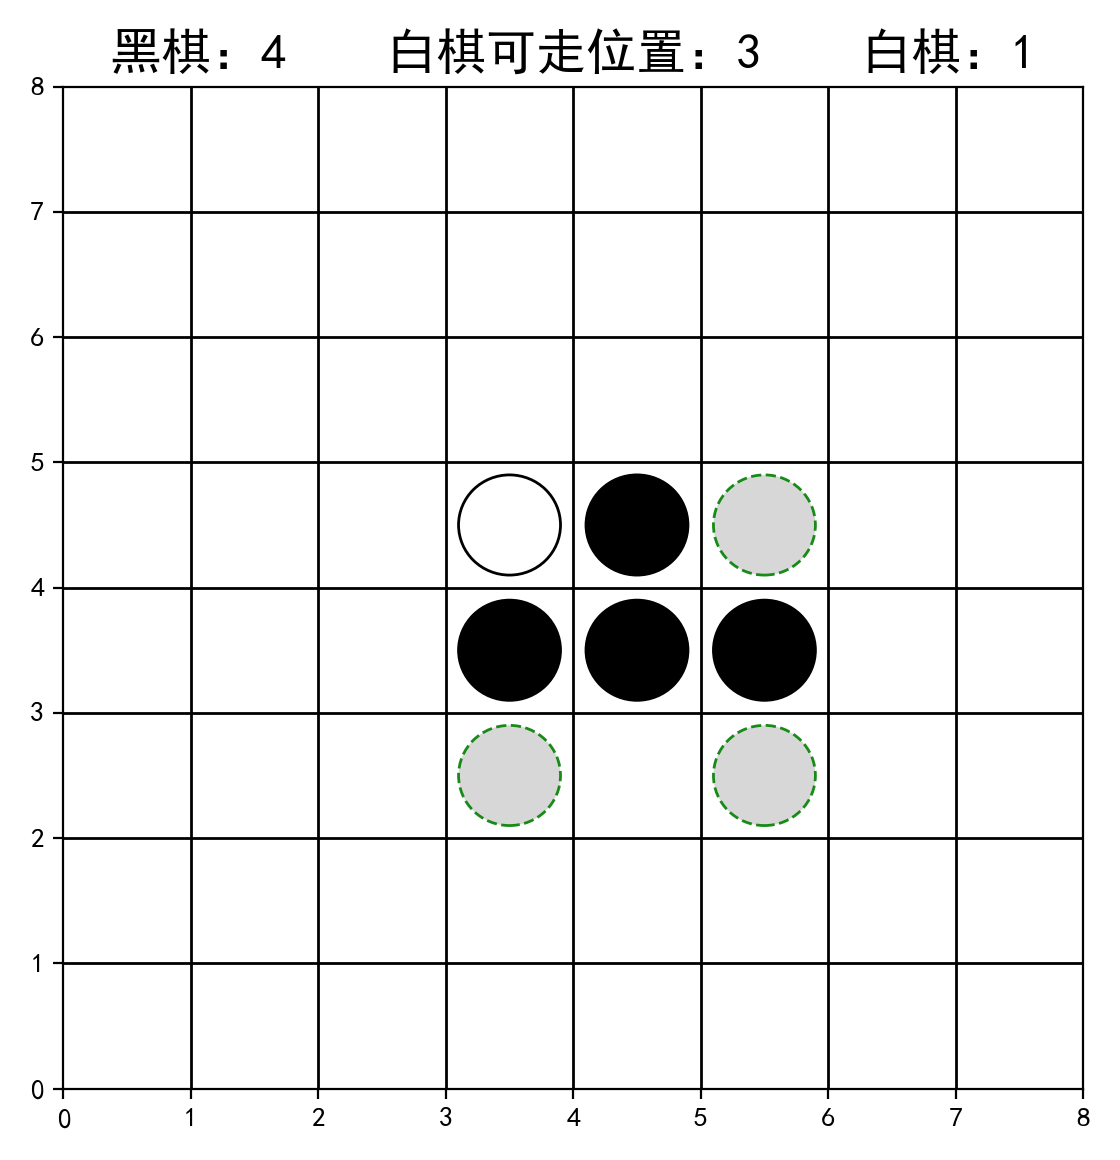

In [3]:
# WBChess 可以支持两个人玩
chess = WBChess()
chess.start()

In [110]:
class RandWBChess(WBChess):
    def __init__(self):
        WBChess.__init__(self)
    
    
    def monte_carlo(self):
        time.sleep(1)
        lst = []
        for i in range(self.x_max):
            for j in range(self.y_max):
                if self.mat[i][j] == 2:
                    lst.append((i, j))
        return random.choice(lst)
    
    def start(self):
        def hook():
            if self._status == 1 and self.player == -1: # 如果正在进行，且白棋执子
                x, y = self.monte_carlo()
                self.play(x, y)
        cnt = self.find_available_pos(self.player)
        self.draw(set_listener=True, hook=hook)

# RandWBChess: AI是随机落子的
chess = RandWBChess()
chess.start()

In [4]:
from operator import itemgetter
from tree_format import format_tree

# upper confidence bound tree node
class UCBTNode:
    def __init__(self, mat, player, available, pos=(0,0), parent=None):
        self.mat = mat
        self.player = player
        self.parent = parent
        self.pos = pos

        self.available = available
        self.children = []

        self.score = 0
        self.visit = 0

    def has_available(self):
        return len(self.available) > 0
    
    def __str__(self):
        return "Pos: (%d, %d), %d/%d" % (self.pos[0], self.pos[1], self.score, self.visit)

class NoAvailableException(Exception):
    pass

class AIWBChess(WBChess):
    # level: how difficult the ai is. range: 1 ~ 10
    def __init__(self, level=1, ai_player=-1):
        WBChess.__init__(self)
        self.level = level
        self.round = 200
        self.total = 0
        self.ai_player = ai_player    
        self.MODE = ""
        
    def log_mat(self, mat, message=""):
        logging.info("Simulate result:")
        logging.info(message)
        for i in reversed(range(self.x_max)):
            logging.info(" ".join([str(int(x)) for x in mat[:,i]]))
    
    def log_tree(self, root):
        def build(root):
            obj = (str(root), [])
            if len(root.children) > 0:
                for child in root.children:
                    obj[1].append(build(child))
            return obj
        tree = build(root)
        logging.info("\n" + format_tree(tree, format_node=itemgetter(0), get_children=itemgetter(1)))
    
    # default c is sqrt(2)
    def ucb(self, node, c=1.414):
        a = node.score / node.visit 
        b = c * np.sqrt(np.log(self.total) / node.visit)
        return node.player * (a + b) * (-self.ai_player)

    # create new child node
    def extend(self, node):
        ch = random.choice(node.available)
        node.available.remove(ch)

        tmp_mat = node.mat.copy()
        self.put_piece_pos(node.player, ch[0], ch[1], tmp_mat)

        # self.player * -1 -> 换对方下子
        available = self.find_available_pos(player=node.player * -1, mat=tmp_mat, return_cnt=False)
        kid = UCBTNode(tmp_mat, node.player * -1, available, pos=ch, parent=node)
        node.children.append(kid)
        return kid
    
    def select(self, root):
        while True:
            if root.has_available():
                node = self.extend(root)
                return node
            elif len(root.children) <= 0:
                return root
            else:
                ucb_scores = list(map(lambda x: self.ucb(x), root.children))
                root = root.children[ucb_scores.index(max(ucb_scores))]
            
    def simulate(self, root):
        tmp_mat = root.mat.copy()
        player = root.player
        while True:
            candidate = self.find_available_pos(player=player, mat=tmp_mat, return_cnt=False)
            if len(candidate) <= 0: # 
                break
            addition = [] # 随机模拟时更多考虑边和角，提高模拟效率
            for c in candidate:
                if c[0] == 0:
                    addition.append(c)
                if c[1] == 0:
                    addition.append(c)
            ch = random.choice(candidate + addition)
            self.put_piece_pos(player, ch[0], ch[1], tmp_mat)
            player = player * -1        
        
        w, b = 0, 0
        for i in range(self.x_max):
            for j in range(self.y_max):
                if tmp_mat[i][j] == 1:
                    b += 1
                if tmp_mat[i][j] == -1:
                    w += 1
        del tmp_mat
        logging.debug("Simulate white:%d, black:%d"%(w, b))
        if self.MODE is not None and self.MODE == 'B': # 实验组 B
            if self.ai_player == -1:
                return max((w - b) / 10, 0) # AI执白子
            else:
                return max((b - w) / 10, 0) # AI执黑子
        else:                                          # 对照组 A
            if self.ai_player == -1:
                return max((w - b) / 5, 0) # AI执白子
            else:
                return max((b - w) / 5, 0) # AI执黑子
    
    # 反向传播结果
    def back_propagate(self, root, score):
        while root is not None:
            root.visit += 1
            root.score += score
            root = root.parent
            
    def monte_carlo(self):
        t = time.time()
        tmp_mat = self.mat.copy()
        candidate = self.find_available_pos(player=self.ai_player, mat=tmp_mat, return_cnt=False)
        logging.info("Init candidate: " + str(candidate))
        if len(candidate) == 0:
            raise NoAvailableException()
        root = UCBTNode(tmp_mat, self.ai_player, candidate)
        
        self.total = 0
        for i in range(self.round * self.level):
            node = self.select(root)
            score = self.simulate(node)
            self.back_propagate(node, score)
            self.total += 1
        logging.info("Player %d success rate: %.2f" % (self.player, root.score / root.visit))
        logging.info("\n" + "\n".join([str(x) for x in root.children]))
        sorted_kids = sorted(root.children, key=lambda x:(x.visit, x.score), reverse=True)
        logging.info("Thinking time: %.2f(s)"%(time.time() - t))
        #self.log_tree(root)
        return sorted_kids[0].pos
    
    def start(self):
        def hook():
            if self._status == 1 and self.player == self.ai_player: # 如果正在进行，且白棋执子
                try:
                    x, y = self.monte_carlo()
                    self.play(x, y)
                except Exception as e:
                    logging.error(e, exc_info=True)
        cnt = self.find_available_pos(self.player)
        self.draw(set_listener=True, hook=hook)

<IPython.core.display.Javascript object>


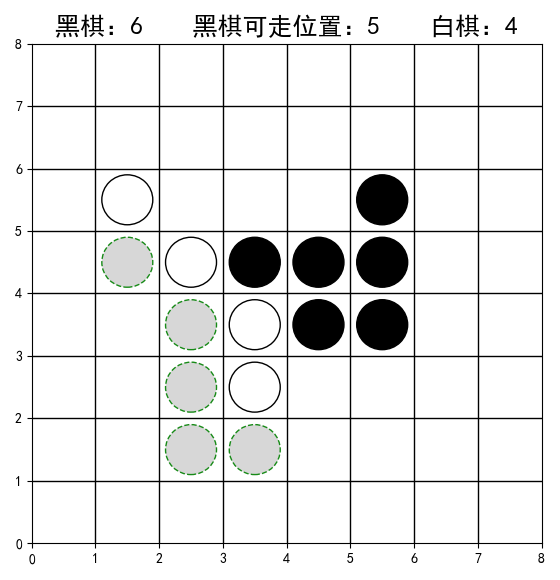

In [9]:
chess = AIWBChess(ai_player=-1)
chess.start()

<IPython.core.display.Javascript object>


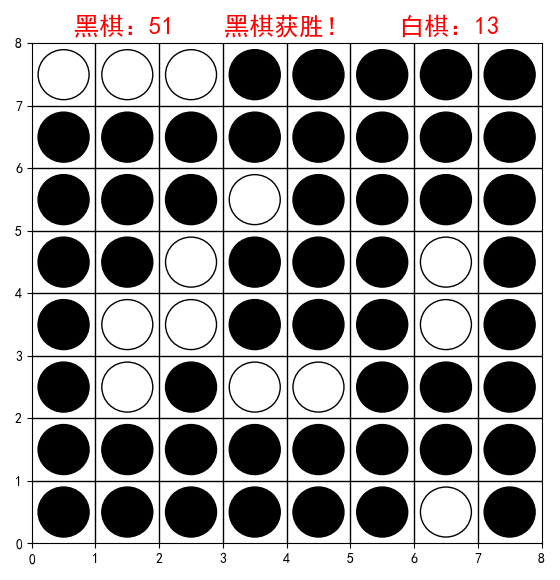

In [10]:
class SelfPlayAIWBChess(AIWBChess):
    # level: how difficult the ai is. range: 1 ~ 10
    def __init__(self, level=1, ai_player=-1):
        AIWBChess.__init__(self, level, ai_player)
        self.draw(set_listener=False)
        

    def start(self):
        self.ai_player = 1 # 黑棋先走
        self.player = self.ai_player
        self.draw(set_listener=False)
        empty_pass = 0
        while True:
            cnt = self.find_available_pos(self.player)
            self.draw(set_listener=False)
            
            # AB测试
            if self.player==1:
                self.MODE = 'B'
            else:
                self.MODE = 'A'
            
            if self._status == 1: # 如果正在进行
                try:
                    x, y = self.monte_carlo()
                    self.play(x, y)
                except NoAvailableException as e:
                    empty_pass += 1
                    if empty_pass > 1:
                        break
                except Exception as e:
                    logging.error(e, exc_info=True)
                self.ai_player *= -1  # 换棋手
                self.player = self.ai_player
                self.draw(set_listener=False)
            else:                     # 结束
                self.draw(set_listener=False)
                break
        return self._black, self._white

chess = SelfPlayAIWBChess()

In [11]:
chess.start()

(51, 13)

In [37]:
# A 白棋 对照组
# B 黑棋 实验组
def abtest(msg, cond):
    winA, winB = 0, 0
    for i in range(20):
        chess.init_mat()
        nb,nw = chess.start()
        if nw > nb:
            winA += 1  
        else:
            winB += 1
        print("%d, %d, %.2f"%(nb, nw, winB / (winA + winB)))
        time.sleep(1)
    better = 'A' if winA>=winB else 'B'
    print(msg)
    print("winA: %d, winB: %d。"%(winA, winB))
    print("%s : %s is Better！" % (better, cond[better]))

## 测试1：使用赢棋子数而不是胜负次数，效果更好

In [34]:
ABTestCond = {'A': '1 if w > b else 0', 'B': 'max((w - b) / 5, 0)'}
abtest("For score calculation:", ABTestCond)

55 9 1.0
52 12 1.0
34 30 1.0
54 9 1.0
30 34 0.8
15 49 0.6666666666666666
15 0 0.7142857142857143
54 10 0.75
56 8 0.7777777777777778
41 23 0.8
19 45 0.7272727272727273
22 42 0.6666666666666666
53 11 0.6923076923076923
22 42 0.6428571428571429
52 12 0.6666666666666666
33 31 0.6875
31 33 0.6470588235294118
47 16 0.6666666666666666
39 25 0.6842105263157895
18 46 0.65
For score calculation:
winA: 7, winB: 13。
B : max((w - b) / 5, 0) is Better！


## 测试2：赢棋子数的系数比较，1/10 略逊于 1/5

In [38]:
ABTestCond = {'A': 'max((w - b) / 5, 0)', 'B': 'max((w - b) / 10, 0)'}
abtest("For score calculation coefficient:", ABTestCond)

57, 3, 1.00
16, 48, 0.50
14, 50, 0.33
11, 53, 0.25
46, 18, 0.40
60, 2, 0.50
14, 50, 0.43
7, 57, 0.38
26, 38, 0.33
14, 46, 0.30
7, 57, 0.27
31, 33, 0.25
6, 58, 0.23
58, 6, 0.29
56, 8, 0.33
56, 8, 0.38
39, 25, 0.41
56, 7, 0.44
25, 39, 0.42
46, 18, 0.45
For score calculation coefficient:
winA: 11, winB: 9。
A : max((w - b) / 5, 0) is Better！


In [93]:
import numpy as np
from copy import deepcopy

class DecisionTree(object):
    #计算熵
    def calcInfoEntropy(self, label):
        label_set = set(label)
        result = 0
        for l in label_set:
            count = 0
            for j in range(len(label)):
                if label[j] == l:
                    count += 1
            p = count/len(label)
            result -= p*np.log2(p)
        return result

    #计算条件熵
    def calcHDA(self, feature, label, index, value):
        count = 0
        sub_feature = []
        sub_label = []
        for i in range(len(feature)):
            if feature[i][index] == value:
                count += 1
                sub_feature.append(feature[i])
                sub_label.append(label[i])
        pHA = count/len(feature)
        e = self.calcInfoEntropy(sub_label)
        return pHA*e


    #计算信息增益
    def calcInfoGain(self, feature, label, index):
        base_e = self.calcInfoEntropy(label)
        f = np.array(feature)
        f_set = set(f[:, index])
        sum_HDA = 0
        for l in f_set:
            sum_HDA += self.calcHDA(feature, label, index, l)
        return base_e - sum_HDA


    def __init__(self):
        #决策树模型
        self.tree = {}

    def ID3(self, feature, label):
        label_table = {}
        for x in label:
            if x in label_table:
                label_table[x] += 1
            else:
                label_table[x] = 1
        if len(label_table.keys()) < 2:
            return list(label_table.keys())[0]
        all_same = True
        first = feature[0]
        for i in range(1, len(label)):
            for j in range(len(first)):
                if feature[i][j] != first[j]:
                    all_same = False
                    break
            if not all_same:
                break
        if all_same:
            return sorted([(k, v)for k,v in label_table.items()], key=lambda x: x[1], reverse=True)[0][0]
        
        gains = [self.calcInfoGain(feature, label, x) for x in range(len(feature[0]))]
        best_feature_idx = gains.index(max(gains))

        value_set, tree = set(), {best_feature_idx:{}}
        for i in range(len(label)):
            value_set.add(feature[i][best_feature_idx])
        for val in value_set:
            sub_feature = []
            sub_label = []
            for i in range(len(feature)):
                row = feature[i]
                if row[best_feature_idx] == val:
                    sub_feature.append(row)
                    sub_label.append(label[i])
            tree[best_feature_idx][val] = self.ID3(sub_feature, sub_label)
        return tree

    def fit(self, feature, label):
        '''
        :param feature: 训练数据集所有特征组成的ndarray
        :param label:训练数据集中所有标签组成的ndarray
        :return: None
        '''

        #************* Begin ************#
        self.tree = self.ID3(feature, label)
        #************* End **************#

    def predict(self, feature):
        '''
        :param feature:训练数据集所有特征组成的ndarray
        :return:预测结果，如np.array([0, 1, 2, 2, 1, 0])
        '''

        #************* Begin ************#
        res = []
        for row in feature:
            tree = self.tree
            while isinstance(tree ,dict):
                idx = list(tree.keys())[0]
                tree = tree[idx][row[idx]]
            res.append(tree)
        return res
        #************* End **************#

In [94]:
params = {'feature':[[0, 1], [1, 0], [1, 2], [0, 0], [1, 1]], 'label':[0, 1, 0, 0, 1], 'index': 0}
calcInfoGain(params['feature'], params['label'], params['index'])

0.9709505944546686
{0: 2, 1: 3}
0.0
0.5509775004326938


0.4199730940219748

In [95]:
tree = DecisionTree()
tree.fit(params['feature'], params['label'])

In [96]:
tree.predict(params['feature'])

[0, 1, 0, 0, 1]

In [81]:
tree.tree

{0: {0: 0, 1: {1: {0: 1, 1: 1, 2: 0}}}}